#<b><font color="blue" size=6.5>LeNet-5 Implementation using Pytorch<font></b>

<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/lenet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 1. Set up**

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm 

device = torch.device("cuda")

## *Dataset and DataLoader*

In [2]:
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage

train_dataset = MNIST('/files/', train=True, download=True, transform=ToTensor())
test_dataset = MNIST('/files/', train=False, download=True, transform=ToTensor())

train_dataset, valid_dataset = random_split(train_dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

print("There are", len(train_dataset), "images in the training data.")
print("There are", len(valid_dataset), "images in the validation data.")
print("There are", len(test_dataset), "images in the testing data.")

There are 54000 images in the training data.
There are 6000 images in the validation data.
There are 10000 images in the testing data.


In [3]:
first_image = train_dataset[0][0]
print("Shape of input:", first_image.shape)

first_image = ToPILImage()(first_image)
first_target = train_dataset[0][1]
display(first_image)
print("First target:", first_target)

Shape of input: torch.Size([1, 28, 28])


First target: 6


In [4]:
# DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

## *Network Structure*

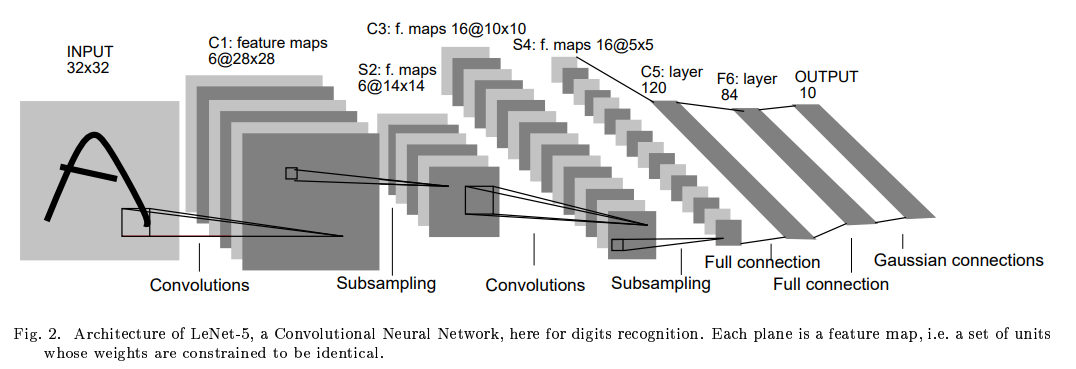

In [5]:
from torch.nn import Conv2d, Sigmoid, AvgPool2d, Flatten, Linear, Sequential

class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = Sequential(
        Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), padding=2),
        Sigmoid(),
        AvgPool2d(kernel_size=(2, 2), stride=2),

        Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
        Sigmoid(),
        AvgPool2d(kernel_size=(2, 2), stride=2),

        nn.Flatten(),

        Linear(in_features=5*5*16, out_features=120),
        Sigmoid(),
        Linear(120, 84),
        Sigmoid(),
        Linear(in_features=84, out_features=10)
   )

  def forward(self, x):
    return  self.net(x)

In [6]:
model = LeNet5()
X = torch.randn((1, 1, 28, 28))
for layer in model.net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


## *Test / Validation Step*

In [7]:
def validate(model, dataloader, device=torch.device("cuda")):
  model.eval()
  batch_acc = []

  with torch.no_grad():
    for images, targets in dataloader:
      images = images.to(device)
      targets = targets.to(device)
      preds = model(images)
      pred_labels = torch.argmax(preds, dim=1)
      correct = (pred_labels == targets).sum().item()
      total = len(targets)
      batch_acc.append(correct/total)
  
  return batch_acc

## *Training Step*

In [8]:
def train(
    model,
    optimizer,
    criterion,
    train_dataloader,
    valid_dataloader,
    num_epochs = 10,
    device=torch.device("cuda")
):

  model.train()

  for epoch in range(num_epochs):

    ## Training Steps
    batch_losses = []
    process = tqdm(train_dataloader, position=0, leave=True)
    for images, targets in process:
        images, targets = images.to(device),  targets.to(device)  ## Step 1: Move input data to device
        preds = model(images)                                     ## Step 2: Run the model on the input data
        loss = criterion(preds, targets)                          ## Step 3: Calculate the loss
        optimizer.zero_grad()                                     ## Step 4: Perform backpropagation
        loss.backward()
        optimizer.step()                                          ## Step 5: Update the parameters

        loss_value = loss.detach().item()
        batch_losses.append(loss_value)
        process.set_description(f'Epoch [{epoch+1}/{num_epochs}]') ## Update progress bar
        process.set_postfix({'loss': loss_value})

    ## Validation Steps
    valid_acc = validate(model, valid_dataloader, device)

    ## Show current status 
    print(f"Train Loss: {np.mean(batch_losses):.3f}, Valid Acc:{np.mean(valid_acc):.3f}")

  ## Save model state dict after training
  torch.save(model.state_dict(), "model_state_dict.ckpt")

# **Section 2. Start Training**

## *Optimization Configuration*

In [9]:
model = LeNet5()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## *Start Training*

In [10]:
train(model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs=5)

Epoch [1/5]: 100%|██████████| 422/422 [00:14<00:00, 29.61it/s, loss=0.141]


Train Loss: 1.335, Valid Acc:0.952


Epoch [2/5]: 100%|██████████| 422/422 [00:08<00:00, 48.24it/s, loss=0.029]


Train Loss: 0.109, Valid Acc:0.973


Epoch [3/5]: 100%|██████████| 422/422 [00:09<00:00, 44.59it/s, loss=0.0406]


Train Loss: 0.061, Valid Acc:0.982


Epoch [4/5]: 100%|██████████| 422/422 [00:09<00:00, 45.31it/s, loss=0.0251]


Train Loss: 0.044, Valid Acc:0.981


Epoch [5/5]: 100%|██████████| 422/422 [00:08<00:00, 47.64it/s, loss=0.0288]


Train Loss: 0.036, Valid Acc:0.984


## *Test your result*

In [11]:
test_model = LeNet5()
test_model.to(device)
trained_state_dict = torch.load("model_state_dict.ckpt")
test_model.load_state_dict(trained_state_dict)
print("Final Acc:", np.mean(validate(test_model, test_dataloader)))

Final Acc: 0.9870450949367089
